In [1]:
!pip install --upgrade tensorflow

     |████████████████████████████████| 86.3MB 28kB/s 
     |████████████████████████████████| 450kB 41.2MB/s 
     |████████████████████████████████| 3.8MB 36.0MB/s 
     |████████████████████████████████| 81kB 11.3MB/s 
ERROR: tensorboard 2.0.2 has requirement grpcio>=1.24.3, but you'll have grpcio 1.15.0 which is incompatible.
ERROR: google-colab 1.0.0 has requirement google-auth~=1.4.0, but you'll have google-auth 1.8.1 which is incompatible.
  Found existing installation: tensorflow-estimator 1.15.1
    Uninstalling tensorflow-estimator-1.15.1:
      Successfully uninstalled tensorflow-estimator-1.15.1
  Found existing installation: google-auth 1.4.2
    Uninstalling google-auth-1.4.2:
      Successfully uninstalled google-auth-1.4.2
  Found existing installation: tensorboard 1.15.0
    Uninstalling tensorboard-1.15.0:
      Successfully uninstalled tensorboard-1.15.0
  Found existing installation: tensorflow 1.15.0
    Uninstalling tensorflow-1.15.0:
      Successfully uninstalle

In [8]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.vgg19 import VGG19
print(tf.__version__)

2.0.0


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
%cd drive/'My Drive'/BME590_Machine_Learning

[Errno 2] No such file or directory: 'drive/My Drive/BME590_Machine_Learning'
/content/drive/My Drive/BME590_Machine_Learning


In [0]:
from scipy.io import loadmat
data = loadmat('OASBUD.mat')['data'][0] # mat file is dict with header, we just want the data key (which is stored as a list of lists)
# each of the 100 data points consists of 7 arrays
# array 0: patient's unique ID
# array 1: first scan plane (first set of rf dta)
# array 2: second scan plane (second set of rf data)
# array 3: region of interest for first scan plane
# array 4: region of interest for second scan plane
# array 5: BI-RADS category (low, medium, high probability of malignancy)
# array 6: label (0 = benign, 1 = malignant)

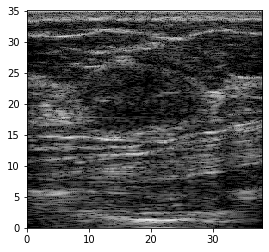

In [9]:
from scipy.signal import hilbert
# example image processing of first data point (both scan planes):
c = 1540
width = 38
fs = 40e6
rf1 = data[0][1]
roi1 = data[0][3]

def preprocessing(rf_data, db_threshold):
    envelope_image = np.abs(hilbert(rf_data))
    envelope_image = 20 * np.log10(envelope_image/np.max(envelope_image))
    envelope_image[envelope_image < -1.0*db_threshold] = -1.0*db_threshold
    return 255.0*(envelope_image + db_threshold)/(db_threshold)    
    
preprocessed=preprocessing(rf1,50)
plt.imshow(preprocessed,extent=[0,width,0,rf1.shape[0]*500*c/fs],cmap='gray')
plt.show()

In [0]:
%reset_selective -f data, rf1, roi1, envelope_image, preprocessed

In [0]:
# to get data and labels for all scans
dB_cutoff= tf.Variable(50)
labeled_data = []
for n in range(len(data)):
  labeled_data.append((preprocessing(data[n][1],dB_cutoff.numpy()), data[n][3], data[n][6][0])) # data for scan 1, roi for scan 1, label
  labeled_data.append((preprocessing(data[n][2],dB_cutoff.numpy()), data[n][4], data[n][6][0])) # data for scan 2, roi for scan 2, label

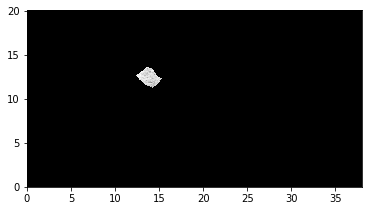

In [11]:
c = 1540
width = 38
fs = 40e6
rf1 = labeled_data[70][0]
# rf2 = data[0][2]
roi1 = labeled_data[70][1]
# roi2 = data[0][4]

def preprocessing(rf_data, db_threshold):
    envelope_image = np.abs(hilbert(rf_data))
    envelope_image = 20 * np.log10(envelope_image/np.max(envelope_image))
    envelope_image[envelope_image < -1.0*db_threshold] = -1.0*db_threshold
    return 255.0*(envelope_image + db_threshold)/(db_threshold)    
    
preprocessed=preprocessing(rf1,50)*roi1
plt.imshow(preprocessed,extent=[0,width,0,rf1.shape[0]*500*c/fs],cmap='gray')
plt.show()

In [0]:
# Augment data with random cropping
import random
def augment_data(labeled_data):
  augmented_labeled_data = []
  crop_size = 200 # 128
  for data in labeled_data:
    #ctr += 1
    count = 0
    lower_perc = .16
    while count < 50:
      # print(count, end='')
      num_bad = 1
      start_x = random.randint(0, np.size(data[0], 0) - crop_size)
      start_y = random.randint(0, np.size(data[0], 1) - crop_size)
      new_roi = data[1][start_x:start_x+crop_size, start_y:start_y+crop_size]
      num_ones = np.count_nonzero(new_roi == 1)
      while not ((crop_size**2)*lower_perc < num_ones < (crop_size**2)*.9):
        # print(count, end='')
        start_x = random.randint(0, np.size(data[0], 0) - crop_size)
        start_y = random.randint(0, np.size(data[0], 1) - crop_size)
        new_roi = data[1][start_x:start_x+crop_size, start_y:start_y+crop_size]
        num_ones = np.count_nonzero(new_roi == 1)
        num_bad = num_bad + 1
        if num_bad%20 == 0:
          # print(num_bad, lower_perc)
          lower_perc = lower_perc/2
      count = count + 1
      augmented_labeled_data.append((data[0][start_x:start_x+crop_size, start_y:start_y+crop_size], data[2]))
      # augmented_labeled_data.append((np.fliplr(data[0][start_x:start_x+crop_size, start_y:start_y+crop_size]), data[2]))
      # augmented_labeled_data.append((np.flipud(data[0][start_x:start_x+crop_size, start_y:start_y+crop_size]), data[2]))
  return np.array(augmented_labeled_data)

augmented_labeled_data = augment_data(labeled_data)

In [28]:
print(augmented_labeled_data.shape)
print(augmented_labeled_data[0][1].shape)

(10000, 2)
(1,)


In [0]:
%reset_selective -f rf3, roi3, envelope_image

In [0]:
# x = np.array([x[0] for x in augmented_labeled_data])
# y_class = np.array([x[2] for x in augmented_labeled_data])
# divide by max, put on gaussian 
# x_max = np.abs([x[0] for x in augmented_labeled_data]).max()
# x = [x/np.abs(x).max() for x in x]
x_max = 255

# Data splitting for classification
# x_train_class,x_test_class,y_train_class,y_test_class = \
#     train_test_split([x[0]/x_max for x in augmented_labeled_data],[x[1] for x in augmented_labeled_data],test_size=.2,random_state=13, shuffle=False)

In [0]:
random.shuffle(augmented_labeled_data)

In [0]:
# New train_test_split

# train_data = augmented_labeled_data[:int(len(augmented_labeled_data)*.8)]
# test_data = augmented_labeled_data[int(len(augmented_labeled_data)*.8):]
x_train_class = augmented_labeled_data[:int(len(augmented_labeled_data)*.8),0]
y_train_class = augmented_labeled_data[:int(len(augmented_labeled_data)*.8),1]
x_test_class = augmented_labeled_data[int(len(augmented_labeled_data)*.8):,0]
y_test_class = augmented_labeled_data[int(len(augmented_labeled_data)*.8):,1]

In [39]:
print(x_train_class.shape)
print(x_train_class[0].shape)
print(y_train_class.shape)

(8000,)
(200, 200)
(8000,)


In [0]:
# del labeled_data, augmented_labeled_data
# %reset_selective -f labeled_data, augmented_labeled_data

In [0]:
# print(np.array(x_train_class).shape)

In [0]:
# x_train_class = np.array([np.stack((x, x, x), axis=2) for x in x_train_class])
# x_test_class = np.array([np.stack((x, x, x), axis=2) for x in x_test_class])
x_train_class = [x[:,:] for x in x_train_class][..., np.newaxis]
x_test_class = [x[:,:] for x in x_test_class][..., np.newaxis]
# y_train_class = y_train_class
# y_test_class = y_test_class


In [56]:
print(x_train_class.shape)

(320000000,)


In [0]:
# import cv2
# x_train_class = [cv2.cvtColor(gray,cv2.COLOR_GRAY2RGB) for gray in x_train_class]
# x_test_class = [cv2.cvtColor(gray,cv2.COLOR_GRAY2RGB) for gray in x_test_class]
# y_train_class = [cv2.cvtColor(gray,cv2.COLOR_GRAY2RGB) for gray in y_train_class]
# y_test_class = [cv2.cvtColor(gray,cv2.COLOR_GRAY2RGB) for gray in y_test_class]

In [0]:
train_ds_class = tf.data.Dataset.from_tensor_slices((np.asarray(x_train_class, np.float32), np.asarray(y_train_class, np.float32))).shuffle(10000).batch(128)
test_ds_class = tf.data.Dataset.from_tensor_slices((np.asarray(x_test_class, np.float32), np.asarray(y_test_class, np.float32)))

In [0]:
# %reset_selective labeled_data, augmented_labeled_data

In [0]:
class CNN(tf.keras.Model):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = tf.keras.layers.Conv2D(filters=32, kernel_size=5,strides=1, padding='same', activation='relu')
        self.conv2 = tf.keras.layers.Conv2D(filters=32,kernel_size=5, strides=2,padding='same',activation='relu')
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.conv3 = tf.keras.layers.Conv2D(filters=32, kernel_size=5,strides=1, padding='same', activation='relu')
        self.conv4 = tf.keras.layers.Conv2D(filters=32, kernel_size=5, strides=2,padding='same',activation='relu')
        self.bn2 = tf.keras.layers.BatchNormalization()
        self.conv5 = tf.keras.layers.Conv2D(filters=32, kernel_size=5,strides=1, padding='same', activation='relu')
        self.conv6 = tf.keras.layers.Conv2D(filters=32, kernel_size=5, strides=2,padding='same',activation='relu')
        self.bn3 = tf.keras.layers.BatchNormalization()
        self.flatten = tf.keras.layers.Flatten()
        self.d1 = tf.keras.layers.Dense(128, activation=tf.nn.relu)
        self.do = tf.keras.layers.Dropout(.1)
        self.d2 = tf.keras.layers.Dense(2, activation=tf.nn.softmax)
    def call(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.bn1(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.bn2(x)
        x = self.conv5(x)
        x = self.conv6(x)
        x = self.bn3(x)
        x = self.flatten(x)
        x = self.d1(x)
        x = self.do(x)
        return self.d2(x)

In [0]:
# Physical Layer
# train loop

model = CNN()
tf.keras.utils.plot_model(model, show_shapes=True)
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=.001)

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

@tf.function
def train_step(images, labels):
    with tf.GradientTape() as tape:
        predictions = model(images)
        loss = loss_object(labels, predictions)
        tf.print(tf.argmax(predictions, axis=1), summarize=-1)
        tf.print(labels, summarize=-1)
        tf.print("----")
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    train_loss(loss)
    train_accuracy(labels, predictions)
@tf.function
def test_step(images, labels):
    predictions = model(images)
    t_loss = loss_object(labels, predictions)
    tf.print("TEST:", tf.argmax(predictions, axis=1), summarize=-1)
    tf.print(labels, summarize=-1)
    tf.print("----")
    test_loss(t_loss)
    test_accuracy(labels, predictions)
    
EPOCHS = 3

for epoch in range(EPOCHS):
    i = 0
    for images, labels in train_ds_class:
        # print(images.shape)
        train_step(images, labels)

    for test_images, test_labels in test_ds_class:
        test_step(test_images, test_labels)
        # if i%10 == 0:
        template = 'Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}'
        print(template.format(epoch+1,
                            train_loss.result(),
                            train_accuracy.result()*100,
                            test_loss.result(),
                            test_accuracy.result()*100))
        # i += 1
    # Reset the metrics for the next epoch
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()

In [0]:
# Visualization
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()

plt.plot(results.history['accuracy'])
plt.plot(results.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy (%)')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()

In [0]:
# Physical layer: aperture width - upsampling for decreased aperture width
from scipy import interpolate
interpolation = tf.Variable(1000)
def aperture(data):  # input will be the batch of data passed into it
  sampled = []
  for n in range(len(data)):
    for i in range(1,3):
      x = np.array(range(data[n][i].shape[1]))
      y = np.array(range(data[n][i].shape[0]))
      xx,yy=np.meshgrid(x,y)  
      f = interpolate.interp2d(x, y, data[n][i], kind='linear')
      x2 = np.linspace(0, data[n][i].shape[1], interpolation)
      y2 = np.linspace(0, data[n][i].shape[0], interpolation)
      sampled.append(f(x2,y2))
  return sampled

sample=np.array(aperture(data))
print(sample.shape)

# Other physical layer: dB threshold used to process images
db_threshold = tf.Variable(50)
def preprocessing(rf_data): # input will be the raw rf data passed into it
    envelope_image = np.abs(hilbert(rf_data))
    envelope_image = 20 * np.log10(envelope_image/np.max(envelope_image))
    envelope_image[envelope_image < -1.0*db_threshold] = -1.0*db_threshold
    return 255.0*(envelope_image + db_threshold)/(db_threshold) 